In [ ]:
# Cell 0 — environment check
import torch, torchvision
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


PyTorch: 2.8.0+cu126
CUDA available: True
Device: cuda


In [ ]:
# Cell 1 — install + imports
!pip -q install scikit-learn tqdm

import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import save_image, make_grid
from PIL import Image


In [ ]:
# Cell 2 — fetch LFW and save N images to /content/lfw_small
from sklearn.datasets import fetch_lfw_people
out_dir = "/content/lfw_small"
os.makedirs(out_dir, exist_ok=True)

# Parameters: change N_images to 50 if you want fastest test
N_images = 300        # recommended: 200-1000. Set to 50 for quick debug.
resize = 0.5          # smaller images -> faster training

print("Downloading LFW (this may take ~10-60s depending on network)...")
faces = fetch_lfw_people(min_faces_per_person=20, resize=resize)  # downloads if missing
print("Total LFW images fetched:", faces.images.shape[0])

# Randomly pick N_images (fixed seed for reproducibility)
rng = np.random.RandomState(42)
idxs = rng.choice(faces.images.shape[0], size=min(N_images, faces.images.shape[0]), replace=False)

# Save as RGB PNGs
for i, idx in enumerate(idxs):
    arr = faces.images[idx]
    # fetch_lfw returns grayscale floats in [0,255] typically
    if arr.max() <= 1.0:
        arr = (arr * 255).astype(np.uint8)
    else:
        arr = arr.astype(np.uint8)
    pil = Image.fromarray(arr).convert("RGB")
    fname = f"img_{i:04d}.png"
    pil.save(os.path.join(out_dir, fname))

print("Saved", len(os.listdir(out_dir)), "images to", out_dir)


Total LFW images fetched: 3023
Saved 300 images to /content/lfw_small


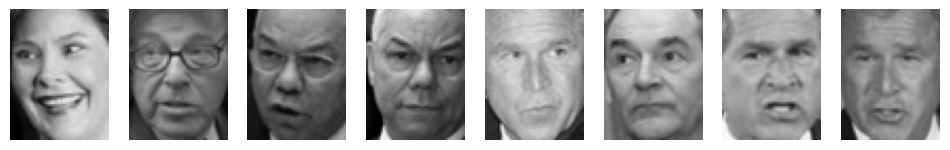

In [ ]:
# Cell 3 — preview a few saved images
import matplotlib.image as mpimg
files = sorted([f for f in os.listdir(out_dir) if f.endswith(".png")])[:8]
plt.figure(figsize=(12,4))
for i,f in enumerate(files):
    img = mpimg.imread(os.path.join(out_dir,f))
    plt.subplot(1,8,i+1); plt.imshow(img); plt.axis("off")
plt.show()


In [ ]:
# Cell 4 — DataLoader for flat image folder
image_size = 64     # consistent with model below
batch_size = 16     # start small. Increase if GPU memory allows (32/64)
num_workers = 2     # set 0 if Colab gives issues

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])  # map to [-1,1]
])

class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform: img = self.transform(img)
        return img

dataset = FlatImageDataset(root_dir=out_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

print("Dataset size:", len(dataset))
imgs = next(iter(dataloader))
print("Batch shape:", imgs.shape)  # should be (batch_size, 3, 64, 64)


Dataset size: 300
Batch shape: torch.Size([16, 3, 64, 64])


In [ ]:
# Cell 5 — Models and weight init
latent_dim = 100

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, z_dim=latent_dim, out_channels=3, ngf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False), # 4x4
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), # 8x8
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False), # 16x16
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),   # 32x32
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, out_channels, 4, 2, 1, bias=False), #64x64
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, ndf, 4, 2, 1, bias=False),     # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),           # 16x16
            nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),         # 8x8
            nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),         # 4x4
            nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),             # 1x1
        )
    def forward(self, x):
        out = self.net(x).view(-1)   # shape [batch]
        return out

# Instantiate and init
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

print("Generator params:", sum(p.numel() for p in generator.parameters()))
print("Discriminator params:", sum(p.numel() for p in discriminator.parameters()))


Generator params: 3576704
Discriminator params: 2765568


In [ ]:
# Cell 6 — criterion & optimizers
criterion = nn.BCEWithLogitsLoss()   # expects logits from Discriminator
lr = 2e-4
beta1 = 0.5

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # for visual checkpoints


In [ ]:
# Cell 7 — training loop (runs, saves images per epoch)
num_epochs = 25     # start here; increase to 100-200 later for better results
sample_dir = "/content/samples"
os.makedirs(sample_dir, exist_ok=True)

step = 0
for epoch in range(1, num_epochs+1):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}")
    for i, real_imgs in enumerate(pbar):
        real_imgs = real_imgs.to(device)
        bsize = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(bsize, device=device)
        fake_labels = torch.zeros(bsize, device=device)

        # ---- Train Discriminator ----
        discriminator.zero_grad()
        logits_real = discriminator(real_imgs)                       # shape [bsize]
        loss_real = criterion(logits_real, real_labels)

        noise = torch.randn(bsize, latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        logits_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(logits_fake, fake_labels)

        lossD = (loss_real + loss_fake) * 0.5
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        generator.zero_grad()
        logits_gen = discriminator(fake_imgs)
        lossG = criterion(logits_gen, real_labels)  # try to fool discriminator
        lossG.backward()
        optimizerG.step()

        step += 1
        if step % 100 == 0:
            pbar.set_postfix({'lossD':lossD.item(), 'lossG':lossG.item()})

    # Save sample grid at end of epoch
    with torch.no_grad():
        samples = generator(fixed_noise).cpu()
    save_image(samples, os.path.join(sample_dir, f"generated_epoch_{epoch}.png"), nrow=8, normalize=True)
    print(f"Saved sample for epoch {epoch}")


Epoch 1/25: 100%|██████████| 18/18 [00:02<00:00,  8.73it/s]


Saved sample for epoch 1


Epoch 2/25: 100%|██████████| 18/18 [00:00<00:00, 29.09it/s]


Saved sample for epoch 2


Epoch 3/25: 100%|██████████| 18/18 [00:00<00:00, 29.43it/s]


Saved sample for epoch 3


Epoch 4/25: 100%|██████████| 18/18 [00:00<00:00, 28.98it/s]


Saved sample for epoch 4


Epoch 5/25: 100%|██████████| 18/18 [00:00<00:00, 33.93it/s]


Saved sample for epoch 5


Epoch 6/25: 100%|██████████| 18/18 [00:00<00:00, 39.13it/s, lossD=0.496, lossG=17.8]


Saved sample for epoch 6


Epoch 7/25: 100%|██████████| 18/18 [00:00<00:00, 38.67it/s]


Saved sample for epoch 7


Epoch 8/25: 100%|██████████| 18/18 [00:00<00:00, 39.26it/s]


Saved sample for epoch 8


Epoch 9/25: 100%|██████████| 18/18 [00:00<00:00, 36.93it/s]


Saved sample for epoch 9


Epoch 10/25: 100%|██████████| 18/18 [00:00<00:00, 39.39it/s]


Saved sample for epoch 10


Epoch 11/25: 100%|██████████| 18/18 [00:00<00:00, 38.90it/s]


Saved sample for epoch 11


Epoch 12/25: 100%|██████████| 18/18 [00:00<00:00, 39.22it/s, lossD=0.088, lossG=8.07]


Saved sample for epoch 12


Epoch 13/25: 100%|██████████| 18/18 [00:00<00:00, 39.06it/s]


Saved sample for epoch 13


Epoch 14/25: 100%|██████████| 18/18 [00:00<00:00, 39.18it/s]


Saved sample for epoch 14


Epoch 15/25: 100%|██████████| 18/18 [00:00<00:00, 38.10it/s]


Saved sample for epoch 15


Epoch 16/25: 100%|██████████| 18/18 [00:00<00:00, 38.75it/s]


Saved sample for epoch 16


Epoch 17/25: 100%|██████████| 18/18 [00:00<00:00, 38.65it/s, lossD=0.412, lossG=14.9]


Saved sample for epoch 17


Epoch 18/25: 100%|██████████| 18/18 [00:00<00:00, 37.84it/s]


Saved sample for epoch 18


Epoch 19/25: 100%|██████████| 18/18 [00:00<00:00, 39.38it/s]


Saved sample for epoch 19


Epoch 20/25: 100%|██████████| 18/18 [00:00<00:00, 38.91it/s]


Saved sample for epoch 20


Epoch 21/25: 100%|██████████| 18/18 [00:00<00:00, 39.05it/s]


Saved sample for epoch 21


Epoch 22/25: 100%|██████████| 18/18 [00:00<00:00, 37.74it/s]


Saved sample for epoch 22


Epoch 23/25: 100%|██████████| 18/18 [00:00<00:00, 35.82it/s, lossD=0.168, lossG=4.76]


Saved sample for epoch 23


Epoch 24/25: 100%|██████████| 18/18 [00:00<00:00, 28.42it/s]


Saved sample for epoch 24


Epoch 25/25: 100%|██████████| 18/18 [00:00<00:00, 29.24it/s]


Saved sample for epoch 25


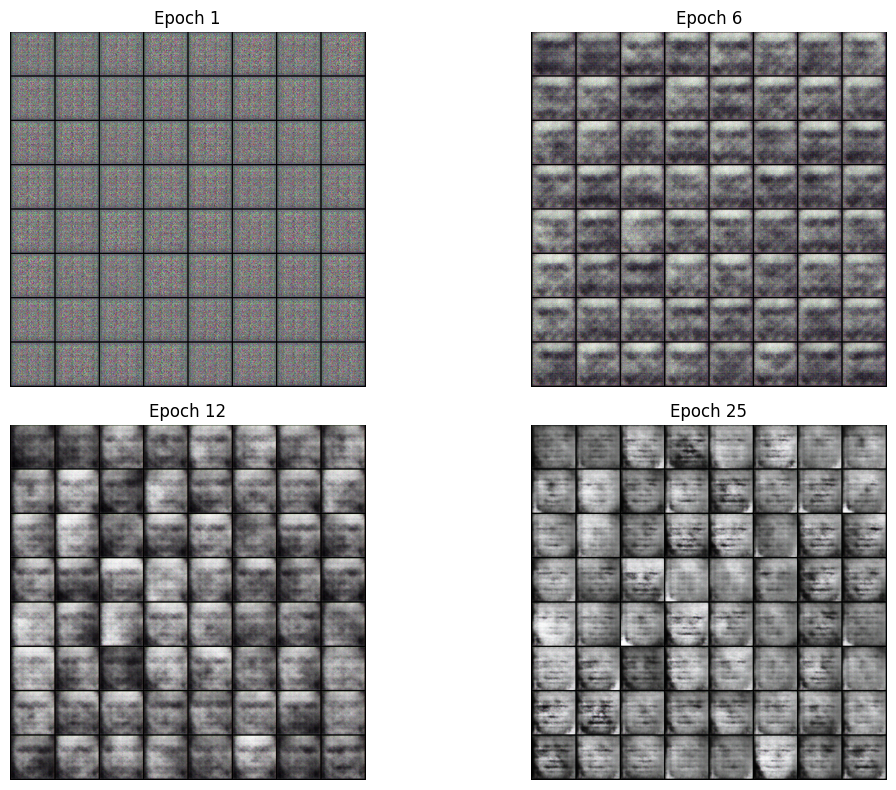

In [ ]:
# Cell 8 — visualize checkpoints
import matplotlib.image as mpimg
epochs_to_show = [1, max(1, num_epochs//4), max(1, num_epochs//2), num_epochs]
plt.figure(figsize=(12,8))
for i,e in enumerate(epochs_to_show):
    path = os.path.join(sample_dir, f"generated_epoch_{e}.png")
    if os.path.exists(path):
        img = mpimg.imread(path)
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        plt.title(f"Epoch {e}")
        plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 9 — save model weights
torch.save(generator.state_dict(), "/content/generator.pth")
torch.save(discriminator.state_dict(), "/content/discriminator.pth")
print("Saved generator.pth and discriminator.pth")


Saved generator.pth and discriminator.pth


In [ ]:
# Recreate architecture, then:
generator = Generator().to(device)
generator.load_state_dict(torch.load("/content/generator.pth", map_location=device))
generator.eval()


Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

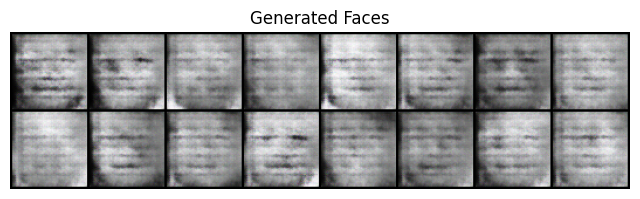

In [ ]:
# Cell 10: Load the saved Generator and generate new faces
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Recreate the architecture and load weights
generator = Generator().to(device)
generator.load_state_dict(torch.load("generator.pth", map_location=device))
generator.eval()

# Generate random noise as input
noise = torch.randn(16, 100, 1, 1, device=device)

# Generate fake images
fake_images = generator(noise).detach().cpu()

# Plot the generated faces
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Faces")
plt.imshow(
    np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0))
)
plt.show()


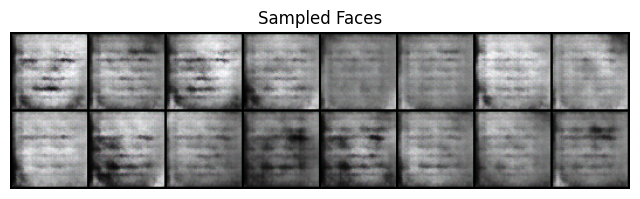

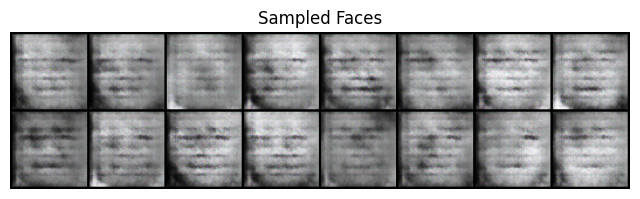

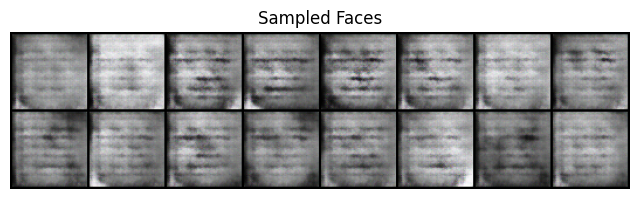

In [ ]:
# Cell 11: Face Sampler - generate faces with different random seeds
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_faces(num_samples=16):
    noise = torch.randn(num_samples, 100, 1, 1, device=device)
    fake_images = generator(noise).detach().cpu()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Sampled Faces")
    plt.imshow(
        np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0))
    )
    plt.show()

# Generate 3 different sets of faces
for i in range(3):
    generate_faces(16)


In [ ]:
import torch

# Example: simulate "DNA features" as binary/categorical encoded vectors
def generate_dna_features(batch_size, num_features=5):
    return torch.randint(0, 2, (batch_size, num_features)).float()


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, dna_dim=5, img_channels=3):
        super(Generator, self).__init__()
        self.fc = nn.Linear(noise_dim + dna_dim, 128*8*8)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, dna_features):
        # concatenate noise + DNA features
        x = torch.cat([z, dna_features], dim=1)
        x = self.fc(x)
        x = x.view(-1, 128, 8, 8)
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, dna_dim=5):
        super(Discriminator, self).__init__()
        self.img_net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Linear(128*16*16 + dna_dim, 1)  # Adjusted for 64×64 images

    def forward(self, img, dna_features):
        x = self.img_net(img).view(img.size(0), -1)
        x = torch.cat([x, dna_features], dim=1)
        return self.fc(x)   # logits (no sigmoid, use BCEWithLogitsLoss)


In [ ]:
noise_dim = 100
dna_dim = 5

generator = Generator(noise_dim=noise_dim, dna_dim=dna_dim).to(device)
discriminator = Discriminator(img_channels=3, dna_dim=dna_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
opt_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5,0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5,0.999))


In [ ]:
epochs = 25
for epoch in range(epochs):
    for imgs in dataloader:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # ===== DNA features =====
        dna_real = generate_dna_features(batch_size, num_features=dna_dim).to(device)

        # ====== Train Discriminator ======
        opt_D.zero_grad()
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Real
        real_logits = discriminator(imgs, dna_real)
        d_loss_real = criterion(real_logits, real_labels)

        # Fake
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(z, dna_real)
        fake_logits = discriminator(fake_imgs.detach(), dna_real)
        d_loss_fake = criterion(fake_logits, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        opt_D.step()

        # ====== Train Generator ======
        opt_G.zero_grad()
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(z, dna_real)
        fake_logits = discriminator(fake_imgs, dna_real)
        g_loss = criterion(fake_logits, real_labels)

        g_loss.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x8197 and 32773x1)